In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torchvision import transforms
import torch.optim as optim
import numpy as np
import gym
import os
import pandas as pd
import warnings

from models import MDRNNCell, VAE, Controller, MDRNN
from train_mdn import *

warnings.simplefilter("ignore")

In [2]:
device = "cuda"
time_limit = 1000
discrete = 0

# Load models
rollout = RolloutGenerator(device, time_limit, discrete)

In [3]:
cumulative, rollout_current_hidden, rollout_next_hidden, rollout_latents, rollout_actions, rollout_rewards, rollout_dones = rollout.do_rollout()

In [4]:
print("Cumulative reward: ", cumulative)
print("Rollout current hidden: ", rollout_current_hidden.shape)
print("Rollout next hidden: ", rollout_next_hidden.shape)
print("Rollout latents: ", rollout_latents.shape)
print("Rollout actions: ", rollout_actions.shape)
print("Rollout rewards: ", rollout_rewards.shape)
print("Rollout dones: ", rollout_dones.shape)

Cumulative reward:  392.26241134751604
Rollout current hidden:  (510, 1, 256)
Rollout next hidden:  (510, 1, 256)
Rollout latents:  (511, 32)
Rollout actions:  (510, 3)
Rollout rewards:  (510,)
Rollout dones:  (510,)


In [9]:
dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'best_1_1_G' in f]

num = -1
idx = 0
file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('G')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        file = fi
        num = Gnum
        
file_path = dir_path + file
file_path

'./results/best_1_1_G399.p'

In [10]:
ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE = 3, 32, 256, 64, 64

s = torch.load(file_path) # ファイルから個体をロード
mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5).to(device)
mdrnn.load_state_dict(s['mdrnn'])
mdrnn

MDRNNCell(
  (gmm_linear): Linear(in_features=256, out_features=327, bias=True)
  (rnn): LSTMCell(35, 256)
)

In [7]:
def gmm_loss(batch, mus, sigmas, logpi, reduce=True):
    """1step MDN-RNNの損失関数

    params:
        batch: (B, *) バッチ
        mus: (B, K, A) 平均
        sigmas: (B, K, A) 分散
        logpi: (B, K) log(pi)
        reduce: bool, default True
    """
    batch = batch.unsqueeze(-2)
    sigmas = torch.abs(sigmas)
    normal_dist = Normal(mus, sigmas)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob

In [7]:
# rnnレイヤーの重みを固定
for param in mdrnn.rnn.parameters():
    param.requires_grad = False

mdn = mdrnn.gmm_linear
mdn_input = rollout_next_hidden.reshape(-1, RSIZE)
mdn_input = torch.tensor(mdn_input, dtype=torch.float32, device=device)
mdn_out = mdn(mdn_input)
mus = mdn_out[:, :5 * LSIZE].reshape(-1, 5, LSIZE)
sigmas = mdn_out[:, 5 * LSIZE: 2*5*LSIZE].reshape(-1, 5, LSIZE)
pi = mdn_out[:, 2*5*LSIZE:2*5*LSIZE+5].reshape(-1, 5)
logpi = F.log_softmax(pi, dim=-2)
reward = mdn_out[:, -2]
done = mdn_out[:, -1]

print("True State: ", rollout_latents[1:].shape)
print("True Reward: ", rollout_rewards.shape)
print("Mus: ", mus.shape)
print("Sigmas: ", sigmas.shape)
print("Logpi: ", logpi.shape)
print("Reward: ", reward.shape)
print("Done: ", done.shape)

True State:  (510, 32)
True Reward:  (510,)
Mus:  torch.Size([510, 5, 32])
Sigmas:  torch.Size([510, 5, 32])
Logpi:  torch.Size([510, 5])
Reward:  torch.Size([510])
Done:  torch.Size([510])


In [9]:
rollout_latents = torch.tensor(rollout_latents, dtype=torch.float32, device=device)

loss = gmm_loss(rollout_latents[1:], mus[:-1], sigmas[:-1], logpi[:-1], reduce=True)

In [10]:
loss

tensor(2808.7278, device='cuda:0', grad_fn=<NegBackward0>)

In [18]:
def reward_loss(batch, rewards, reduce=True):
    """rewardの対数オッズ

    params:
        batch: (B, *) バッチ
        reward: (B, *) reward
        reduce: bool, default True
    """
    loss = nn.BCEWithLogitsLoss(reduction='none')
    reward_loss = loss(batch, rewards)

    if reduce:
        return - torch.mean(reward_loss)
    return - reward_loss

In [12]:
rollout_rewards = torch.tensor(rollout_rewards, dtype=torch.float32, device=device).view(-1, 1)
rollout_rewards.cpu()
reward = reward.view(-1, 1)
reward.cpu()

print("Rollout Rewards: ", rollout_rewards.shape)
print("Reward: ", reward.shape)

Rollout Rewards:  torch.Size([1002, 1])
Reward:  torch.Size([1002, 1])


In [19]:
loss = reward_loss(rollout_rewards, reward, reduce=True)

In [20]:
loss

tensor(-0.8885, device='cuda:0', grad_fn=<NegBackward0>)

In [3]:
dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'best_1_1_G' in f]

num = -1
idx = 0
file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('G')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        file = fi
        num = Gnum
        
file_path = dir_path + file
file_path

'./results/best_1_1_G399.p'

In [4]:
import os

dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'mdn_' in f]

num = -1
idx = 0
checkpoint_file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('_')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        checkpoint_file = fi
        num = Gnum
        
checkpoint_path = dir_path + checkpoint_file
checkpoint_path

'./results/'

In [5]:
def gmm_loss(batch, mus, sigmas, logpi, reduce=True):
    """1step MDN-RNNの損失関数

    params:
        batch: (B, *) バッチ
        mus: (B, K, A) 平均
        sigmas: (B, K, A) 分散
        logpi: (B, K) log(pi)
        reduce: bool, default True
    """
    batch = batch.unsqueeze(-2)
    normal_dist = Normal(mus, torch.abs(sigmas)+1e-8)
    g_log_probs = normal_dist.log_prob(batch)
    g_log_probs = logpi + torch.sum(g_log_probs, dim=-1)
    max_log_probs = torch.max(g_log_probs, dim=-1, keepdim=True)[0]
    g_log_probs = g_log_probs - max_log_probs

    g_probs = torch.exp(g_log_probs)
    probs = torch.sum(g_probs, dim=-1)

    log_prob = max_log_probs.squeeze() + torch.log(probs)
    if reduce:
        return - torch.mean(log_prob)
    return - log_prob

In [ ]:
def convert_binary(batch):
    """バイナリに変換

    params:
        batch: (B, *) バッチ
    """
    binary_batch = torch.where(batch > 0, torch.tensor(1.0), torch.tensor(0.0))

    return binary_batch

def reward_loss(batch, rewards, reduce=True, device='cuda'):
    """rewardの対数オッズ

    params:
        batch: (B, *) バッチ
        reward: (B, *) reward
        reduce: bool, default True
    """
    weight = torch.tensor([100.0], dtype=torch.float32, device=device)
    weight = weight.view(-1, 1)
    loss = nn.BCEWithLogitsLoss(reduction='none', pos_weight=weight)
    binary_batch = convert_binary(batch)
    sigmoid_reward = torch.sigmoid(rewards)
    reward_loss = loss(sigmoid_reward, binary_batch)

    if reduce:
        return torch.mean(reward_loss)
    return reward_loss

In [8]:
# device = "cuda"
# time_limit = 2000
# discrete = 0
# epoch = 2000
# rollout = RolloutGenerator(device, time_limit, discrete)
# rollout.get_rollout(epoch)

100%|██████████| 2000/2000 [2:49:23<00:00,  5.08s/it]  


In [ ]:
dir_path = './results/'
files = os.listdir(dir_path)
files = [f for f in files if 'mdn_' in f]

num = -1
idx = 0
checkpoint_file = ''
for idx, fi in enumerate(files):
    Gnum = fi.split('_')[1].split('.')[0]
    Gnum = int(Gnum)
    if Gnum > num:
        checkpoint_file = fi
        num = Gnum
        
checkpoint_path = dir_path + checkpoint_file

epoch = 2000
device = "cuda"
time_limit = 2000
discrete = 0
epoch_num = 5
ASIZE, LSIZE, RSIZE, RED_SIZE, SIZE = 3, 32, 256, 64, 64

s = torch.load(file_path)
mdrnn = MDRNNCell(LSIZE, ASIZE, RSIZE, 5).to(device)
mdrnn.load_state_dict(s['mdrnn'])

for param in mdrnn.rnn.parameters():
    param.requires_grad = False

mdn = mdrnn.gmm_linear

rollout = RolloutGenerator(device, time_limit, discrete)

optimizer = optim.Adamax(mdn.parameters(), lr=7*1e-4)

rollouts_cumulative, rollouts_current_hidden, rollouts_next_hidden, rollouts_latents, rollouts_actions, rollouts_rewards, rollouts_dones = rollout.get_rollout()
batch_idx = np.arange(len(rollouts_cumulative))

for i in range(epoch_num):
    np.random.shuffle(batch_idx)
    losses = []
    losses_mdn = []
    losses_reward = []
    print("Epoch: ", i+1)
    for j in range(len(rollouts_cumulative)):
        cumulative = rollouts_cumulative[batch_idx[j]].to(device)
        rollout_current_hidden = rollouts_current_hidden[batch_idx[j]].to(device)
        rollout_next_hidden = rollouts_next_hidden[batch_idx[j]].to(device)
        rollout_latents = rollouts_latents[batch_idx[j]].to(device)
        rollout_actions = rollouts_actions[batch_idx[j]].to(device)
        rollout_rewards = rollouts_rewards[batch_idx[j]].to(device)
        rollout_dones = rollouts_dones[batch_idx[j]].to(device)

        rollout_latents = rollout_latents[1:]

        optimizer.zero_grad()

        mdn_input = rollout_next_hidden.reshape(-1, RSIZE)
        mdn_input = torch.tensor(mdn_input, dtype=torch.float32, device=device)
        mdn_out = mdn(mdn_input)
        mus = mdn_out[:, :5 * LSIZE].reshape(-1, 5, LSIZE)
        sigmas = mdn_out[:, 5 * LSIZE: 2*5*LSIZE].reshape(-1, 5, LSIZE)
        pi = mdn_out[:, 2*5*LSIZE:2*5*LSIZE+5].reshape(-1, 5)
        logpi = F.log_softmax(pi, dim=-2)
        reward = mdn_out[:, -2]
        done = mdn_out[:, -1]

        rollout_latents = torch.tensor(rollout_latents, dtype=torch.float32, device=device)
        g_loss = gmm_loss(rollout_latents, mus, sigmas, logpi, reduce=True)

        rollout_rewards = torch.tensor(rollout_rewards, dtype=torch.float32, device=device).view(-1, 1)
        reward = reward.view(-1, 1)
        # print(rollout_rewards.shape)
        # print(reward.shape)
        r_loss = reward_loss(rollout_rewards, reward, reduce=True)

        loss = g_loss + r_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        losses_mdn.append(g_loss.item())
        losses_reward.append(r_loss.item())

        if j % 100 == 0:
            print("Epoch: {}, Batch: {}, Loss: {}, GMM Loss: {}, Reward Loss: {}".format(i+1, j+1, loss.item(), g_loss.item(), r_loss.item()))
            checkpoint = {
                'mdn': mdn.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': i+1,
                'batch': j+1
            }
            torch.save(checkpoint, './results/mdn_{0}_{1}.pth'.format(i+1, j+1))

    print("Epoch: {}, Batch: {}, Loss: {}, GMM Loss: {}, Reward Loss: {}".format(i+1, j+1, loss.item(), g_loss.item(), r_loss.item()))
    print("Finish")

    loss = pd.DataFrame(losses)
    loss_mdn = pd.DataFrame(losses_mdn)
    loss_reward = pd.DataFrame(losses_reward)

    loss.to_csv('./results/loss_{0}.csv'.format(i+1))
    loss_mdn.to_csv('./results/loss_mdn_{0}.csv'.format(i+1))
    loss_reward.to_csv('./results/loss_reward_{0}.csv'.format(i+1))

Epoch: 0, Loss: 2887.525146484375, GMM Loss: 2783.984130859375, Reward Loss: 1.0354100465774536
Epoch: 10, Loss: 2110.102783203125, GMM Loss: 2014.8865966796875, Reward Loss: 0.9521612524986267
Epoch: 20, Loss: 1750.6165771484375, GMM Loss: 1662.0565185546875, Reward Loss: 0.8856009244918823
Epoch: 30, Loss: 1492.0123291015625, GMM Loss: 1400.5894775390625, Reward Loss: 0.9142279624938965
Epoch: 40, Loss: 1443.9949951171875, GMM Loss: 1356.789306640625, Reward Loss: 0.872056782245636
Epoch: 50, Loss: 1426.66796875, GMM Loss: 1337.00341796875, Reward Loss: 0.8966455459594727
Epoch: 60, Loss: 1378.3914794921875, GMM Loss: 1291.23779296875, Reward Loss: 0.8715366125106812
Epoch: 70, Loss: 1185.165771484375, GMM Loss: 1105.912109375, Reward Loss: 0.7925367951393127
Epoch: 80, Loss: 1249.102783203125, GMM Loss: 1166.3153076171875, Reward Loss: 0.8278747200965881
Epoch: 90, Loss: 1185.3365478515625, GMM Loss: 1104.2421875, Reward Loss: 0.8109437227249146
Epoch: 100, Loss: 1056.295166015625, 

KeyboardInterrupt: 

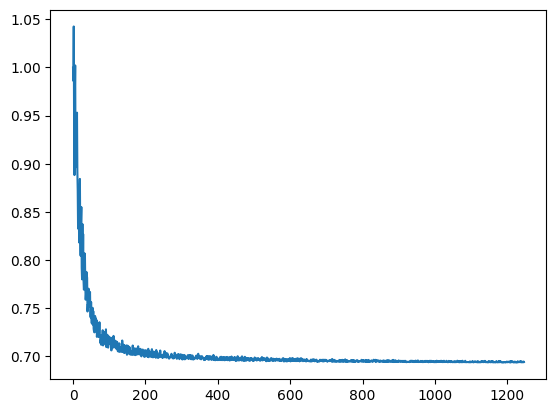

In [8]:
import matplotlib.pyplot as plt

plt.plot(losses_reward)

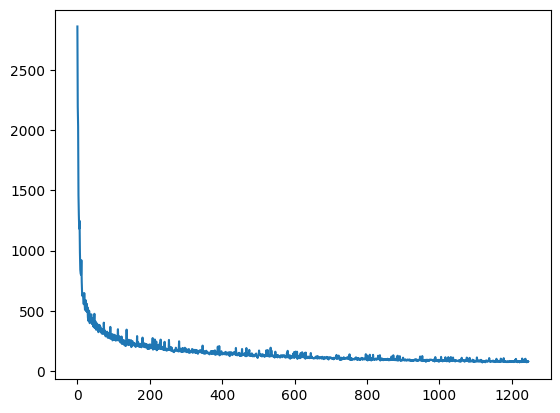

In [9]:
plt.plot(losses)

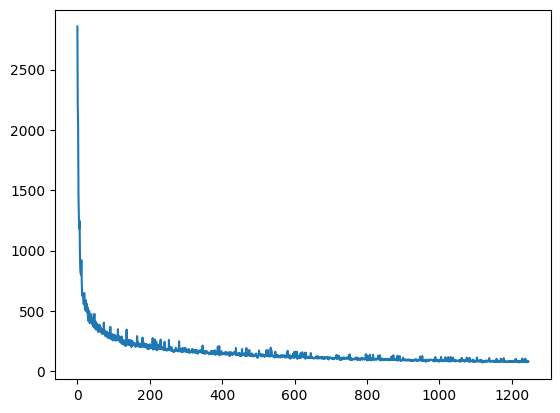

In [10]:
plt.plot(losses_mdn)

In [ ]:
# copy2
# Adamax

# 10 pattern
lr = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 7*1e-4, 7*1e-5]